# Выбор локации для скважины

Нефтедобывающей компании нужно решить, где бурить новую скважину. Компания предоставила пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.

Требуется построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Нужно проанализировать возможную прибыль и риски техникой *Bootstrap*.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

**Загружаем необходимые библиотеки и файлы с данными геологорозведки трёх регионов.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats as st
import numpy as np
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [2]:
try:
    data_1 = pd.read_csv('/datasets/geo_data_0.csv')
except:
    data_1 = pd.read_csv('/choosing_location/geo_data_0.csv')

In [3]:
try:
    data_2 = pd.read_csv('/datasets/geo_data_1.csv')
except:
    data_2 = pd.read_csv('/choosing_location/geo_data_1.csv')

In [4]:
try:
    data_3 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_3 = pd.read_csv('/choosing_location/geo_data_2.csv')

In [5]:
def info_data(name, data):
    print('*' * (len(name) + 8))
    print('Таблица', name)
    print('*' * (len(name) + 8))
    display(data.head())
    print('_' * 50)
    data.info()
    print('_' * 50)
    print('Сводная статистика')
    display(data.describe())
    print('_' * 50)
    print('Корреляция признаков')
    display(data_3.corr(numeric_only=True))
    print('_' * 50)
    print('Количество строк с пропусками:', data.isna().sum().max())
    print('_' * 50)
    print('Количество дубликатов:', data.duplicated().sum())
    print('_' * 50)
    display(data['id'].value_counts())
    print('_' * 50)
    print('Графики распределений признаков')
    data.hist(figsize=(10, 8), color='green')
    plt.show()
    print('_' * 75)

**Изучаем данные первого региона.**

******************
Таблица `Регион 1`
******************


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
__________________________________________________
Сводная статистика


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


__________________________________________________
Корреляция признаков


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


__________________________________________________
Количество строк с пропусками: 0
__________________________________________________
Количество дубликатов: 0
__________________________________________________


fiKDv    2
QcMuo    2
AGS9W    2
Tdehs    2
74z30    2
        ..
x8osI    1
gZ7tR    1
Zw8hj    1
zcrQO    1
1CWhH    1
Name: id, Length: 99990, dtype: int64

__________________________________________________
Графики распределений признаков


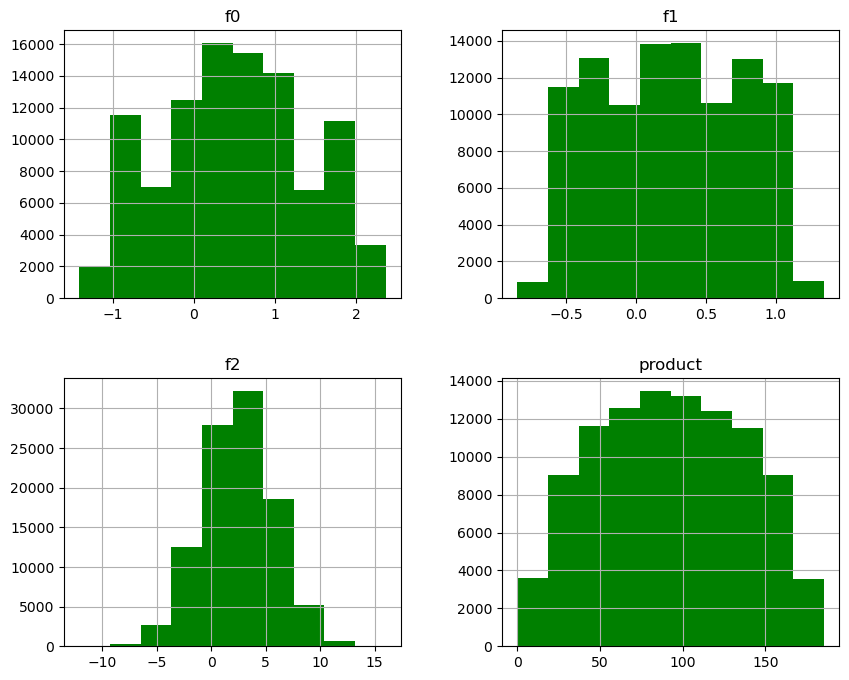

___________________________________________________________________________


In [6]:
info_data('`Регион 1`', data_1)

**Изучаем данные второго региона.**

******************
Таблица `Регион 2`
******************


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
__________________________________________________
Сводная статистика


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


__________________________________________________
Корреляция признаков


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


__________________________________________________
Количество строк с пропусками: 0
__________________________________________________
Количество дубликатов: 0
__________________________________________________


wt4Uk    2
LHZR0    2
5ltQ6    2
bfPNe    2
kBEdx    1
        ..
eup2F    1
5Z8yO    1
HwvM0    1
MZgPf    1
relB0    1
Name: id, Length: 99996, dtype: int64

__________________________________________________
Графики распределений признаков


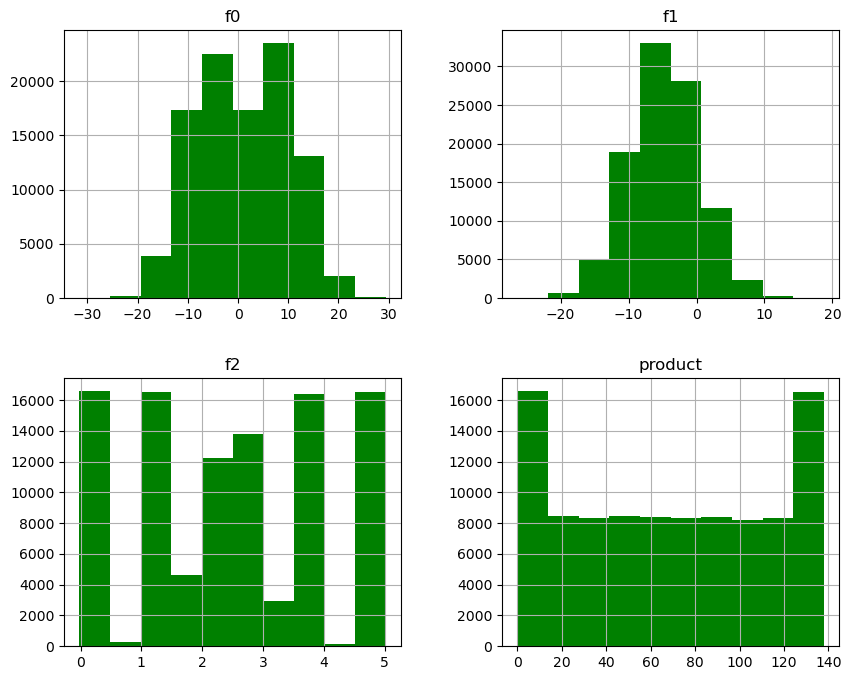

___________________________________________________________________________


In [7]:
info_data('`Регион 2`', data_2)

**Изучаем данные третьего региона.**

******************
Таблица `Регион 3`
******************


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
__________________________________________________
Сводная статистика


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


__________________________________________________
Корреляция признаков


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


__________________________________________________
Количество строк с пропусками: 0
__________________________________________________
Количество дубликатов: 0
__________________________________________________


VF7Jo    2
KUPhW    2
xCHr8    2
Vcm5J    2
fwXo0    1
        ..
bdHH6    1
copuS    1
hZYbu    1
7K1cP    1
V9kWn    1
Name: id, Length: 99996, dtype: int64

__________________________________________________
Графики распределений признаков


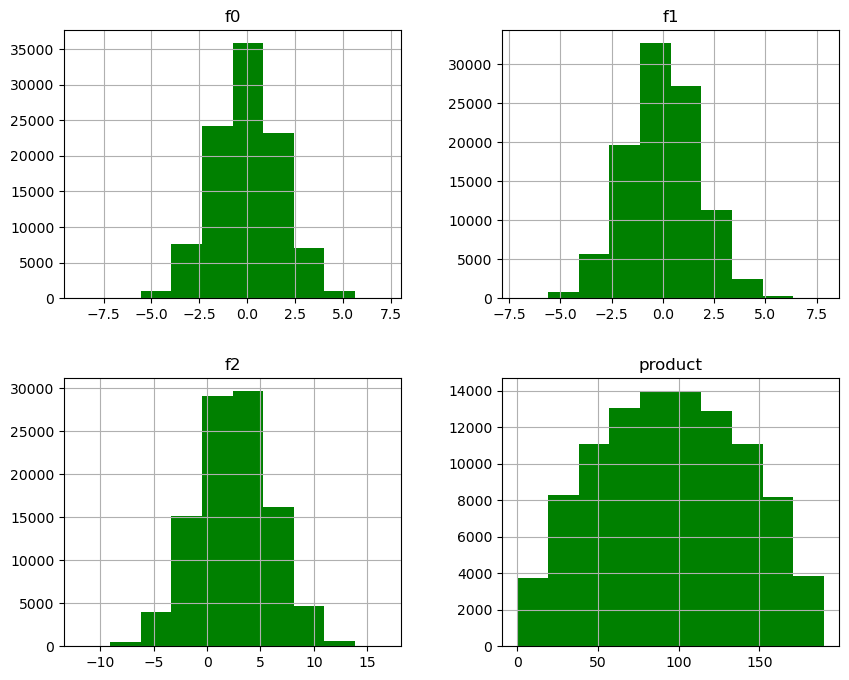

___________________________________________________________________________


In [8]:
info_data('`Регион 3`', data_3)

Данные успешно загружены и изучены, дубликатов нет, предобработка не требуется.

## Обучение и проверка модели

### Разобьём данные на обучающую и валидационную выборки в соотношении 75:25 

**Регион 1**

In [9]:
features_1 = data_1.drop(['id', 'product'], axis=1)
target_1 = data_1['product']

In [10]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345) 

In [11]:
print(features_train_1.shape)
print(target_train_1.shape)
print(features_valid_1.shape)
print(target_valid_1.shape)

(75000, 3)
(75000,)
(25000, 3)
(25000,)


**Регион 2**

In [12]:
features_2 = data_2.drop(['id', 'product'], axis=1)
target_2 = data_2['product']

In [13]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345) 

In [14]:
print(features_train_2.shape)
print(target_train_2.shape)
print(features_valid_2.shape)
print(target_valid_2.shape)

(75000, 3)
(75000,)
(25000, 3)
(25000,)


**Регион 3**

In [15]:
features_3 = data_3.drop(['id', 'product'], axis=1)
target_3 = data_3['product']

In [16]:
features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(
    features_3, target_3, test_size=0.25, random_state=12345) 

In [17]:
print(features_train_3.shape)
print(target_train_3.shape)
print(features_valid_3.shape)
print(target_valid_3.shape)

(75000, 3)
(75000,)
(25000, 3)
(25000,)


Разбили данные на две выборки для каждого региона. Целевой признак - объём сырья, остальные столбцы - численные признаки. Столбец 'id' удалили, так как он не понадобится для дальнейшей работы. Проверили правильность деления на выборки. 

### Обучим модель, сделаем предсказания на валидационной выборке и техникой RMSE оценим качество моделей

**Регион 1**

In [18]:
model_1 = LinearRegression()
model_1.fit(features_train_1,target_train_1)
predict_1 = model_1.predict(features_valid_1)
rmse_1 = mean_squared_error(target_valid_1, predict_1) ** 0.5
print('Предсказанный средний запас сырья: {0:.2f} тыс.баррелей'.format(predict_1.mean()))
print('RMSE модели: {0:.2f}'.format(rmse_1))

Предсказанный средний запас сырья: 92.59 тыс.баррелей
RMSE модели: 37.58


**Регион 2**

In [19]:
model_2 = LinearRegression()
model_2.fit(features_train_2,target_train_2)
predict_2 = model_2.predict(features_valid_2)
rmse_2 = mean_squared_error(target_valid_2, predict_2) ** 0.5
print('Предсказанный средний запас сырья: {0:.2f} тыс.баррелей'.format(predict_2.mean()))
print('RMSE модели: {0:.2f}'.format(rmse_2))

Предсказанный средний запас сырья: 68.73 тыс.баррелей
RMSE модели: 0.89


**Регион 3**

In [20]:
model_3 = LinearRegression()
model_3.fit(features_train_3,target_train_3)
predict_3 = model_3.predict(features_valid_3)
rmse_3 = mean_squared_error(target_valid_3, predict_3) ** 0.5
print('Предсказанный средний запас сырья: {0:.2f} тыс.баррелей'.format(predict_3.mean()))
print('RMSE модели: {0:.2f}'.format(rmse_3))

Предсказанный средний запас сырья: 94.97 тыс.баррелей
RMSE модели: 40.03


### Предсказания и правильные ответы на валидационной выборке

In [21]:
print('Регион 1:')
print(' предсказанный средний запас сырья:', predict_1.mean())
print(' правильные ответы:', target_valid_1.mean())
print()
print('Регион 2')
print(' предсказанный средний запас сырья:', predict_2.mean())
print(' правильные ответы:', target_valid_2.mean())
print()
print('Регион 3')
print(' предсказанный средний запас сырья:', predict_3.mean())
print(' правильные ответы:', target_valid_3.mean())

Регион 1:
 предсказанный средний запас сырья: 92.59256778438035
 правильные ответы: 92.07859674082927

Регион 2
 предсказанный средний запас сырья: 68.72854689544602
 правильные ответы: 68.72313602435997

Регион 3
 предсказанный средний запас сырья: 94.96504596800489
 правильные ответы: 94.88423280885438


### Средний запас предсказанного сырья и RMSE модели

In [22]:
print('Регион 1:')
print(' предсказанный средний запас сырья: {0:.2f} тыс.баррелей'.format(predict_1.mean()))
print(' RMSE модели: {0:.2f}'.format(rmse_1))
print()
print('Регион 2')
print(' предсказанный средний запас сырья: {0:.2f} тыс.баррелей'.format(predict_2.mean()))
print(' RMSE модели: {0:.2f}'.format(rmse_2))
print()
print('Регион 3')
print(' предсказанный средний запас сырья: {0:.2f} тыс.баррелей'.format(predict_3.mean()))
print(' RMSE модели: {0:.2f}'.format(rmse_3))

Регион 1:
 предсказанный средний запас сырья: 92.59 тыс.баррелей
 RMSE модели: 37.58

Регион 2
 предсказанный средний запас сырья: 68.73 тыс.баррелей
 RMSE модели: 0.89

Регион 3
 предсказанный средний запас сырья: 94.97 тыс.баррелей
 RMSE модели: 40.03


Обучили модели, сделали предсказания, сохранили в новых переменных предсказания и правильные ответы на валидационной выборке. RMSE для модели второго региона значительно меньше, чем для двух других, а предсказанный средний объём сырья тоже меньше во втором регионе. Так как среднеквадратичная ошибка для первого и третьего региона довольно большая, можно предположить, что и предсказанные данные по запасам сырья тоже завышены.

## Подготовка к расчёту прибыли

**Ключевые значения для расчётов сохраним в отдельных переменных**

In [23]:
BUDGET = 10000000 #тыс. рублей
INCOME_BARREL = 450 #тыс. рублей - доход за тыс. баррелей
POINTS_DEVEL = 500 #количество исследуемых точек для разработки
POINTS_BEST = 200 #количество лучших точек для разработки

**Найдём наименьший объём сырья для безубыточной разработки скважины**

In [24]:
v_total = BUDGET / INCOME_BARREL
print('Наименьший объём сырья для безубыточной разработки всех скважин в регионе: {0:.2f} тыс. баррелей'.format(v_total))

Наименьший объём сырья для безубыточной разработки всех скважин в регионе: 22222.22 тыс. баррелей


In [25]:
v_min = v_total / POINTS_BEST
print('Наименьший объём сырья для безубыточной разработки каждой скважины: {0:.2f} тыс. баррелей'.format(v_min))

Наименьший объём сырья для безубыточной разработки каждой скважины: 111.11 тыс. баррелей


In [26]:
print('Предсказанные средние запасы сырья в точке по регионам:')
print(' Регион 1: {0:.2f} тыс. баррелей'.format(predict_1.mean()))
print(' Регион 2: {0:.2f} тыс. баррелей'.format(predict_2.mean()))
print(' Регион 3: {0:.2f} тыс. баррелей'.format(predict_3.mean()))

Предсказанные средние запасы сырья в точке по регионам:
 Регион 1: 92.59 тыс. баррелей
 Регион 2: 68.73 тыс. баррелей
 Регион 3: 94.97 тыс. баррелей


Из проведённых расчётов видно, что средний запас сырья в скважине в каждом регионе меньше необходимого объёма для разработки скважины. Поэтому необходимо выбрать скважины с максимальным объёмом сырья.

**Напишем функцию для расчёта прибыли с предсказанных 200 лучших скважин в каждом регионе**

In [27]:
def income(true_target, pred_target):
    sort_Series = pd.Series(pred_target).sort_values(ascending=False)[:POINTS_BEST]
    true_target_sort = (true_target
                         .reset_index(drop = True)[sort_Series.index])
    sum_true = true_target_sort.sum() 
    return round((sum_true * INCOME_BARREL) - BUDGET)

In [28]:
print('Прибыль с лучших 200 скважин в Регионе 1: {0:.2f} тыс. баррелей'.format(income(target_valid_1, predict_1)))
print('Прибыль с лучших 200 скважин в Регионе 2: {0:.2f} тыс. баррелей'.format(income(target_valid_2, predict_2)))
print('Прибыль с лучших 200 скважин в Регионе 3: {0:.2f} тыс. баррелей'.format(income(target_valid_3, predict_3)))

Прибыль с лучших 200 скважин в Регионе 1: 3320826.00 тыс. баррелей
Прибыль с лучших 200 скважин в Регионе 2: 2415087.00 тыс. баррелей
Прибыль с лучших 200 скважин в Регионе 3: 2710350.00 тыс. баррелей


## Расчёт прибыли и рисков 

**Чтобы найти распределение прибыли применим технику Bootstrap с 1000 выборок.**

**Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков для каждого региона**

In [29]:
def income_2(predict,target,count):
    sample = pd.Series(predict).sort_values(ascending=False)
    points = target[sample.index][:count]
    product = points.sum()
    revenue = product * INCOME_BARREL
    return revenue - BUDGET

In [30]:
def bootstap(target,predict):
    samples = []
    count=0
    state = np.random.RandomState(12345)
    predict_1 = pd.Series(predict, index=target.index)
    
    for i in tqdm(range(1000)):
        target_subsample = target.sample(n=POINTS_DEVEL, replace=True, random_state=state)
  
        probs_subsample = predict_1[target_subsample.index]
        samples.append(income_2(probs_subsample,target_subsample, 200))  
    for i in samples:
        if i < 0:
            count +=1
            
    samples = pd.Series(samples)
    mean = samples.mean()
    confidence_interval = st.t.interval(0.95, len(samples)-1, samples.mean(), samples.sem())
    
    lower = samples.quantile(0.025)
    upper = samples.quantile(0.975)   
    print("Средняя прибыль в регионе: {:.2f} млн.руб".format(mean/1000))
    print('95%-й доверительный интервал: {:.2f} - {:.2f} млн.руб'.format((lower/1000),(upper/1000)))
    print ('Вероятность убытка в данном регионе - {:.1%}'.format(count/1000))

In [31]:
bootstap(target_valid_1,predict_1)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 697.43it/s]

Средняя прибыль в регионе: 425.94 млн.руб
95%-й доверительный интервал: -102.09 - 947.98 млн.руб
Вероятность убытка в данном регионе - 6.0%


In [32]:
bootstap(target_valid_2,predict_2)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 698.72it/s]

Средняя прибыль в регионе: 515.22 млн.руб
95%-й доверительный интервал: 68.87 - 931.55 млн.руб
Вероятность убытка в данном регионе - 1.0%


In [33]:
bootstap(target_valid_3,predict_3)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 687.57it/s]

Средняя прибыль в регионе: 435.01 млн.руб
95%-й доверительный интервал: -128.88 - 969.71 млн.руб
Вероятность убытка в данном регионе - 6.4%


Наибольшая средняя прибыль прогнозируется во втором регионе - 515.22 млн.руб. 95%-й доверительный интервал тоже лучший во втором регионе - 68.87 - 931.55 млн.руб. Кроме того второй регион оказался единственным, в котором вероятность убытка не перешла порог в 2,5% и составляет 1%. С учётом всех этих показателей можно сделать вывод, что разработку скважин необходимо делать во втором регионе.

**ВЫВОД**

Нам были предоставлены данные по трём регионам о запасах нефти в 10000 скважин. Поставлена задача опредилить регион, в котором целесообразно начинать нефтедобычу. 

После подготовки данных и разделения их на обучающую и валидационную выборки мы провели обучение моделей методом линейной регрессии для каждого региона, сделали предсказания и проверили качество моделей техникой RMSE. Проведя анализ по этим данным, выяснили, что средний запас сырья в скважинах значительно меньше необходимого запаса для окупаемости разработки скважины.

Чтобы понять целесообразность разработки в каждом регионе, мы выделили по 500 скважин с наибольшим значением предсказаний по запасам сырья и применили технологию `Bootstrap` с разделением каждого предсказанного значения прибыли по регионам на 1000 выборок.

По полученным данным мы определили среднюю прибыль, 95%-й доверительный интервал и вероятность убытка. По этим данным мы выбрали регион для разработки 200 скважин.

Единственным регионом, в котором вероятность убытка прогнозируется меньше заданного 2,5%-го порога - 1%, оказался Регион 2. Этот регион также имеет наилучшие показатели средней прибыли - 515.22 млн.руб и 95%-го доверительного интервала - 68.87 - 931.55 млн.руб.

Исходя из этого деаем вывод - для разработки скважин наиболее перспективным является Регион 2.